In [1]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")

# Reordering

In [3]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total,
        median(reorder) as reorder,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results/reorder.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
reorder_df = con.fetchdf()
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,5.860422e+10
1,row,5.188563e+10


In [4]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        reorder_df r,
        reorder_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
reorder_total_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from reorder_total_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,-0.94375,-1.1


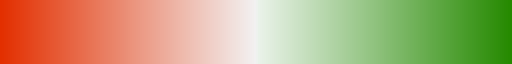

In [5]:
sns.set(font_scale = 1.6)
my_cmap = sns.diverging_palette(15, 125, s=100, l=50, as_cmap=True)
my_cmap

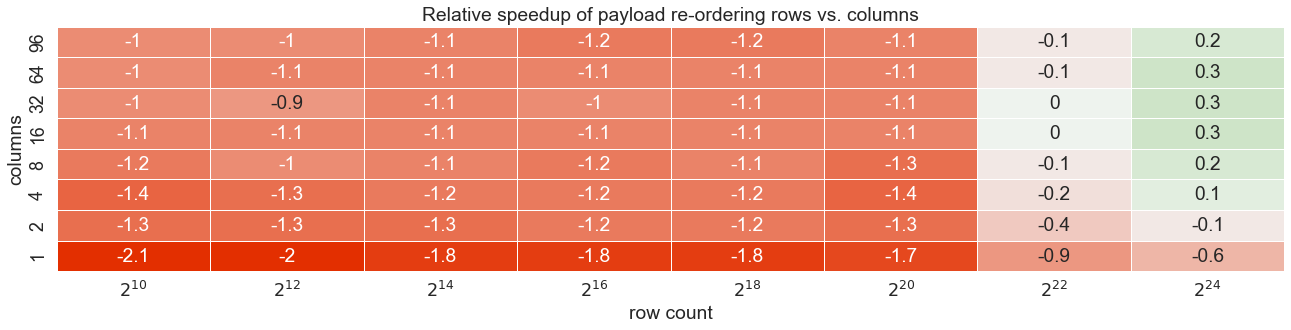

In [6]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_total_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of payload re-ordering rows vs. columns')
plt.show()

In [7]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.reorder as "row reorder",
        c.reorder as "col reorder",
        cast (case when c.reorder > r.reorder then c.reorder / r.reorder - 0.95 else -(r.reorder / c.reorder - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.reorder / r.reorder + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.reorder > r.reorder then c.reorder / r.reorder else -(r.reorder / c.reorder) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.reorder > r.reorder then 1 else -1 end as binary_speedup
    from
        reorder_df r,
        reorder_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
reorder_only_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from reorder_only_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,7.660938,3.9


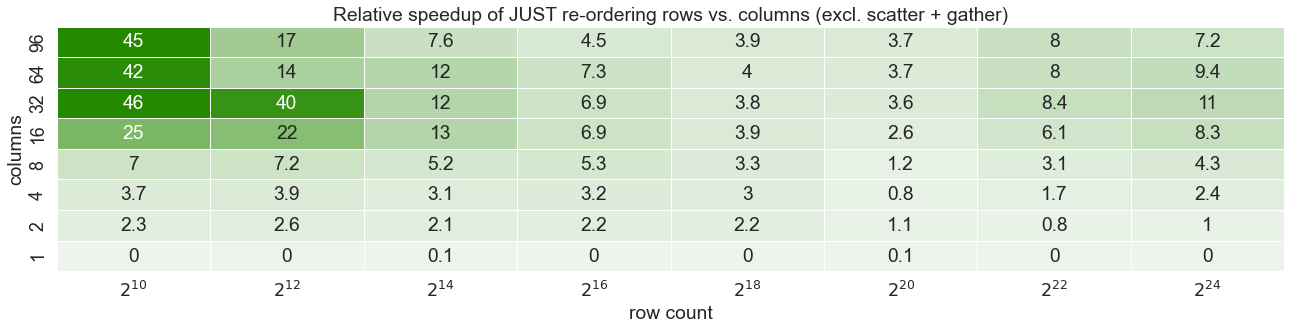

In [8]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_only_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of JUST re-ordering rows vs. columns (excl. scatter + gather)')
plt.show()

In [9]:
con.execute("""
    select
        cast(log2(count) as int) as "row count",
        columns,
        col_width,
        reorder as "row reorder",
        cast(cast(scatter + gather as double) / total as decimal(10,2)) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        "row count" asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.841094,0.885


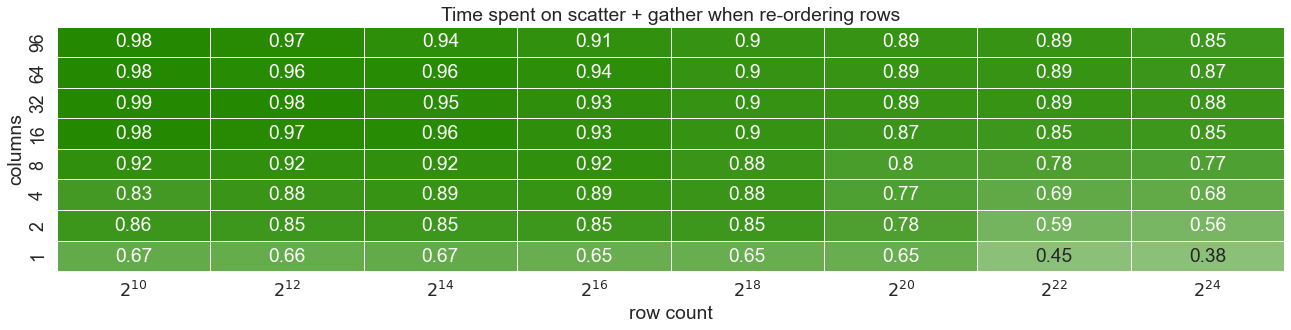

In [10]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_percentage_df.pivot('columns', 'row count', 'sg'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Time spent on scatter + gather when re-ordering rows')
plt.show()

# Comparator

In [11]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        row_id_width,
        col_width,
        median(total) as total,
        median(sort) as sort,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results/comparator.csv')
    group by
        category,
        count,
        columns,
        row_id_width,
        col_width
    order by
        count,
        columns,
        row_id_width,
        col_width,
        category
""")
comparator_df = con.fetchdf()
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,2.287053e+10
1,row_branched,1.747705e+10
2,row_branchless,1.589146e+10


In [12]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branchless'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
comparator_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from comparator_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,0.085938,0.0


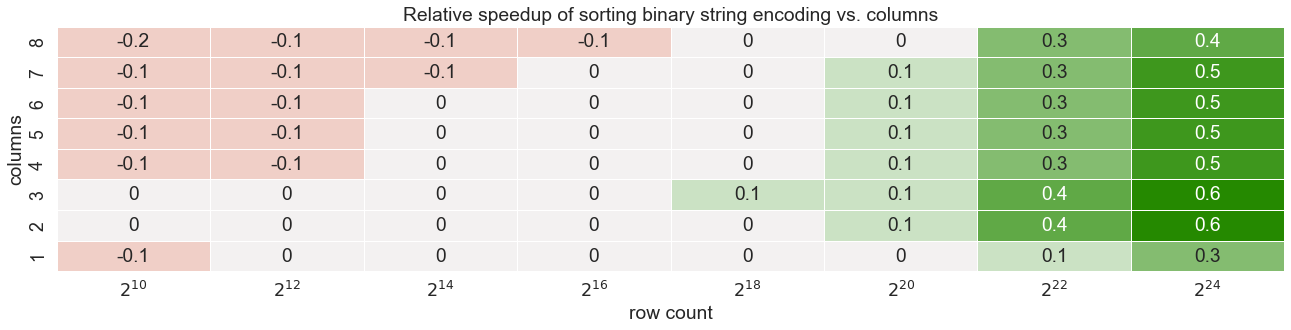

In [13]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(comparator_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of sorting binary string encoding vs. columns')
plt.show()

In [14]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.reorder then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branchless'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
comparator_only_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from comparator_only_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,0.23125,0.1


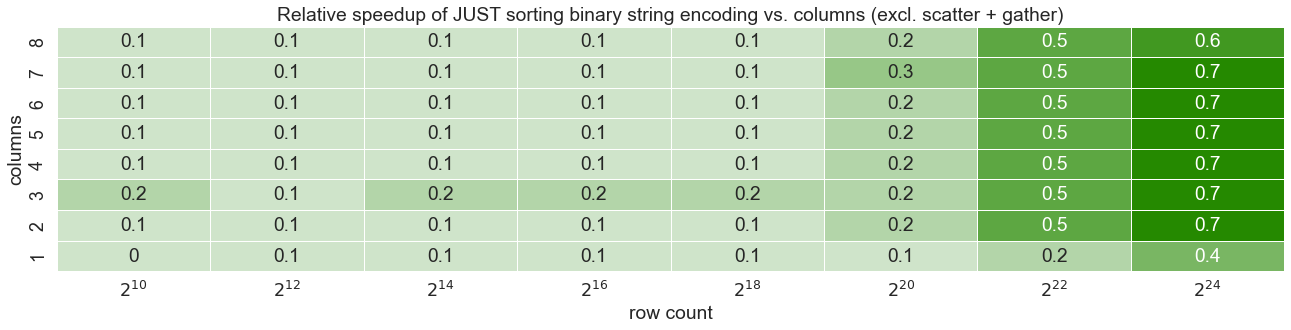

In [15]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(comparator_only_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of JUST sorting binary string encoding vs. columns (excl. scatter + gather)')
plt.show()

# Sort

In [32]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        row_id_width,
        col_width,
        median(total) as total,
        median(sort) as sort,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results/sort.csv')
    group by
        category,
        count,
        columns,
        row_id_width,
        col_width
    order by
        count,
        columns,
        row_id_width,
        col_width,
        category
""")
sort_df = con.fetchdf()
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,rad,7.198591e+09
1,std,1.427457e+10


In [33]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        sort_df r,
        sort_df c
    where
        r.category = 'rad'
    and c.category = 'std'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
sort_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from sort_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,0.659375,0.4


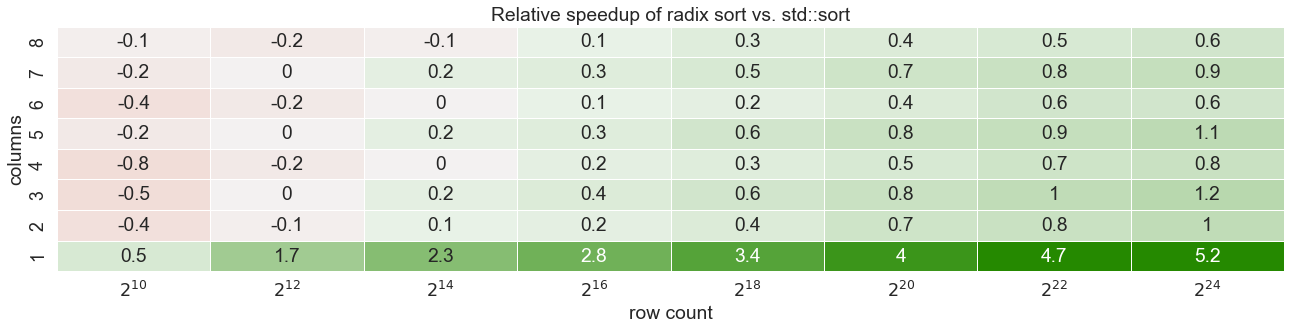

In [35]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(sort_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of radix sort vs. std::sort')
plt.show()

# Merge

In [19]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total
    from
        read_csv_auto('results/merge.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
merge_df = con.fetchdf()
con.execute("select category, sum(total) from merge_df group by category")
con.fetchdf()

,category,sum(total)
0,col,4.483244e+10
1,row,5.784030e+09


In [20]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        merge_df r,
        merge_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
merge_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from merge_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,8.188636,4.45


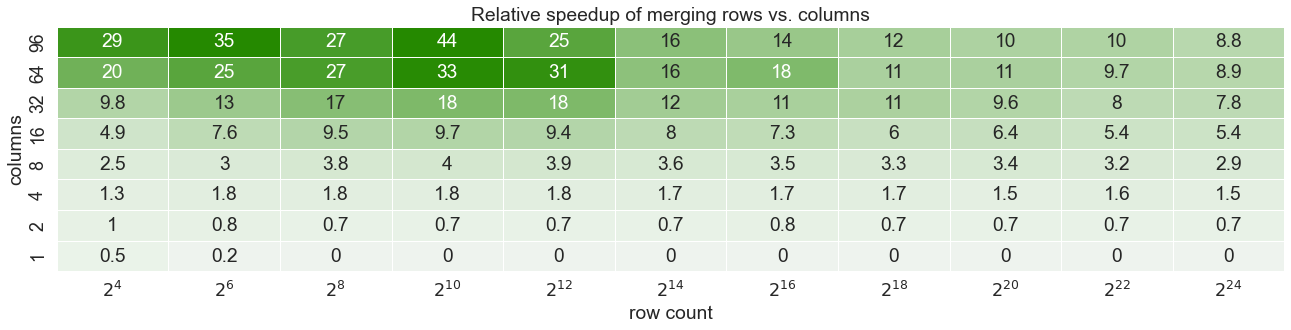

In [21]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(merge_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of merging rows vs. columns')
plt.show()

# Trace

In [22]:
con = duckdb.connect()
con.execute("""
    select
        sim,
        category,
        count,
        columns,
        median(L2_TLB_MISS_DATA) as l2_tlb_miss,
        median(L1D_CACHE_MISS_LD) + median(L1D_CACHE_MISS_ST) as l1_cache_miss,
        median(L1D_TLB_MISS) as l1_tlb_miss
    from
        read_csv_auto('results/trace.csv')
    group by
        sim,
        category,
        count,
        columns
    order by
        sim,
        count,
        columns,
        category
""")
trace_df = con.fetchdf()
trace_df.head()

,sim,category,count,columns,l2_tlb_miss,l1_cache_miss,l1_tlb_miss
0,comparator,col,10,1,673.0,26737.0,3875.0
1,comparator,row,10,1,714.0,28832.0,4170.0
2,comparator,col,10,2,641.0,26448.0,3833.0
3,comparator,row,10,2,683.0,26729.0,4097.0
4,comparator,col,10,3,624.0,28157.0,3919.0


In [23]:
con.execute("""
    select
        r.sim,
        r.count as "row count",
        r.columns,
        r.l1_cache_miss as "row l1 cache miss",
        c.l1_cache_miss as "col l1 cache miss",
        cast(case when c.l1_cache_miss > r.l1_cache_miss then -(c.l1_cache_miss / r.l1_cache_miss - 0.95) else (r.l1_cache_miss / c.l1_cache_miss - 0.95) end as decimal(10,1)) as "cache miss change"
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        trace_df r,
        trace_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.sim = c.sim
    and r.count == c.count
    and r.columns == c.columns
    order by
        "row count" asc,
        columns asc
""")
cache_miss_df = con.fetchdf()
con.execute('select avg("cache miss change"), median("cache miss change") from cache_miss_df')
con.fetchdf()

,avg(cache miss change),median(cache miss change)
0,0.686914,0.0


In [24]:
con.execute("select * from cache_miss_df where sim = 'comparator'")
comparator_df = con.fetchdf()

con.execute("select * from cache_miss_df where sim = 'sort'")
sort_df = con.fetchdf()

con.execute("select * from cache_miss_df where sim = 'reorder'")
reorder_df = con.fetchdf()

con.execute("select * from cache_miss_df where sim = 'merge'")
merge_df = con.fetchdf()

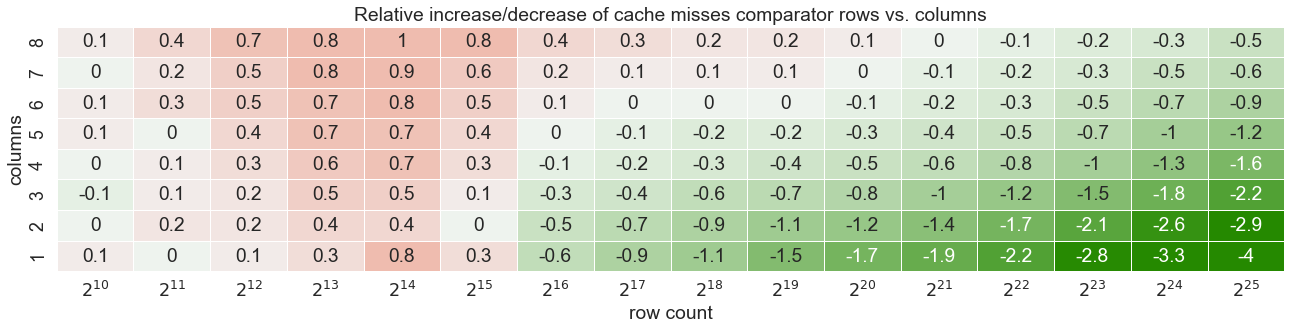

In [25]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(comparator_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses comparator rows vs. columns')
plt.show()

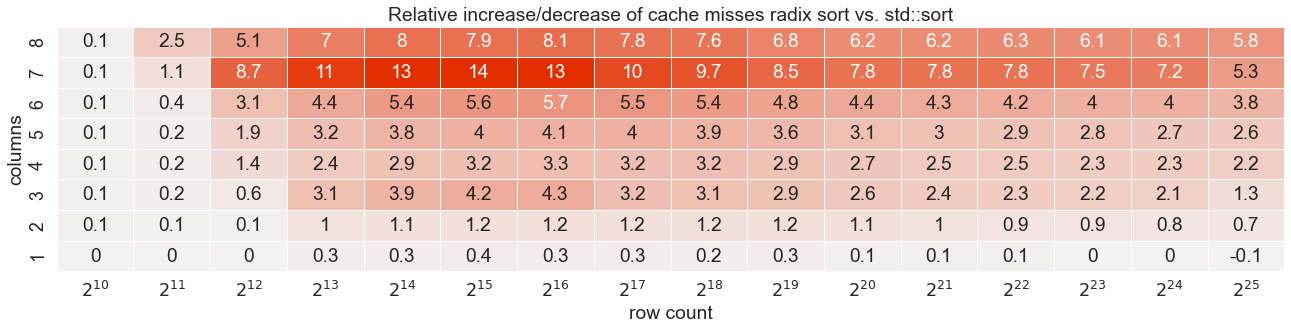

In [26]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(sort_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses radix sort vs. std::sort')
plt.show()

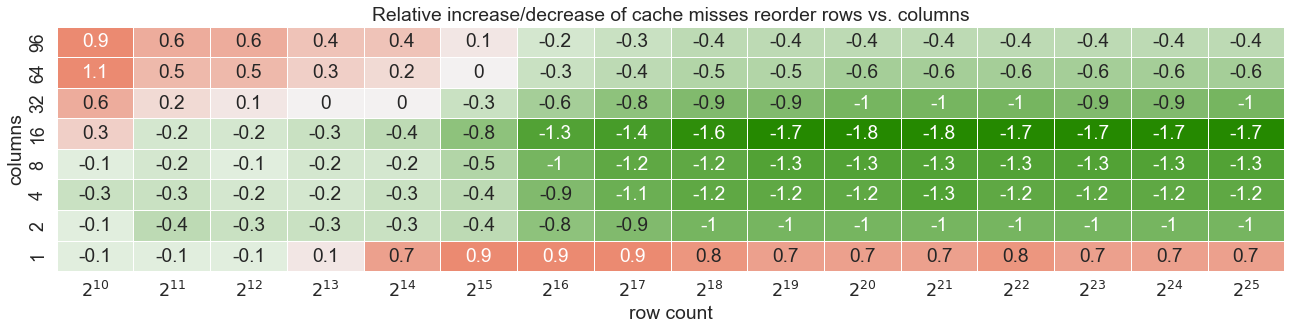

In [27]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses reorder rows vs. columns')
plt.show()

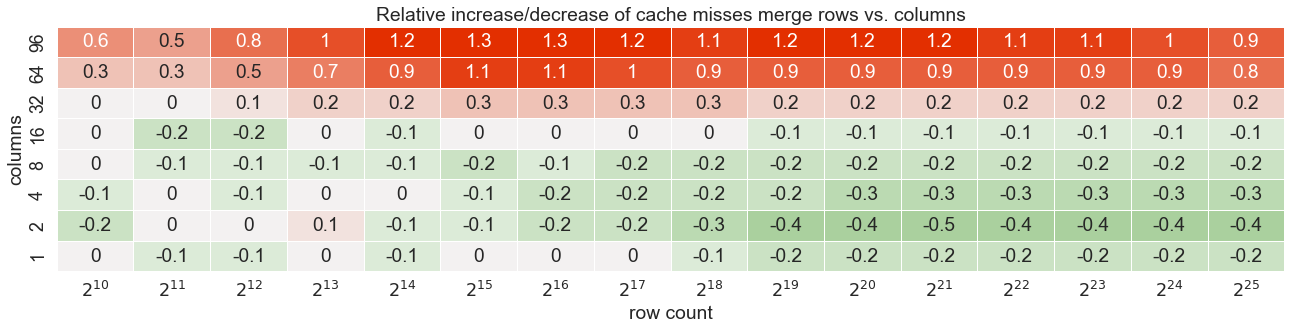

In [28]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(merge_df.pivot('columns', 'row count', 'cache miss change'), linewidths=1, center=0, cmap=my_cmap.reversed(), ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative increase/decrease of cache misses merge rows vs. columns')
plt.show()